# Experiment: MSFT 1-Minute GRU Forecast (Direct Multi-Step v5)

Key changes from v4:
1. **No target standardization** — raw returns prevent zero-collapse
2. **Scale-appropriate Huber** — delta=0.005 matched to 1e-3 return scale
3. **Sigma floor in NLL** — prevents variance collapse
4. **Directional penalty** — penalizes wrong sign prediction
5. **More data** — 120 lookback days (~75+ sessions)
6. **Slower TF decay** — 0.96^epoch keeps TF high longer


In [1]:
# Optional dependency bootstrap
import importlib.util
import subprocess
import sys

required = {
    'alpaca': 'alpaca-py',
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'pandas_market_calendars': 'pandas-market-calendars',
}

missing = [pkg for mod, pkg in required.items() if importlib.util.find_spec(mod) is None]
if missing:
    print('Installing missing packages:', missing)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *missing])
else:
    print('All required third-party packages are already installed.')


All required third-party packages are already installed.


In [2]:
# Setup
from __future__ import annotations

import copy
import os
import random
import time
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import torch
import torch.nn as nn
from alpaca.data.enums import DataFeed
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import DataLoader, Dataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {DEVICE}')
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
    print('CUDA:', torch.version.cuda)


Using device: cuda
GPU: NVIDIA GeForce RTX 3070
CUDA: 12.1


## Configuration

Tuned for direct multi-step forecasting v5: no target standardization, scale-appropriate losses.


In [3]:
# Configuration
SYMBOL = 'MSFT'
LOOKBACK_DAYS = 120

OHLC_COLS = ['Open', 'High', 'Low', 'Close']
RAW_COLS = OHLC_COLS + ['Volume', 'TradeCount', 'VWAP']

BASE_FEATURE_COLS = [
    'rOpen',
    'rHigh',
    'rLow',
    'rClose',
    'logVolChange',
    'logTradeCountChange',
    'vwapDelta',
    'rangeFrac',
    'orderFlowProxy',
    'tickPressure',
]
TARGET_COLS = ['rOpen', 'rHigh', 'rLow', 'rClose']
INPUT_EXTRA_COL = 'imputedFracWindow'

HORIZON = 15
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

LOOKBACK_CANDIDATES = [64, 96, 160, 256]
DEFAULT_LOOKBACK = 96
ENABLE_LOOKBACK_SWEEP = True
SKIP_OPEN_BARS_TARGET = 6

# Model capacity / regularization
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.15
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 256

# Training schedules
SWEEP_MAX_EPOCHS = 12
SWEEP_PATIENCE = 4
FINAL_MAX_EPOCHS = 40
FINAL_PATIENCE = 8
TF_START = 1.0
TF_END = 0.0
TF_DECAY_RATE = 0.96  # slower exponential decay per epoch

# Loss weights
MU_HUBER_WEIGHT = 1.0  # equal weight to NLL
DIR_PENALTY_WEIGHT = 0.10  # directional penalty
HUBER_DELTA = 0.005  # tuned for return scale ~1e-3
NLL_WEIGHTS = np.array([1.0, 1.0, 1.0, 1.0], dtype=np.float32)
HUBER_WEIGHTS = np.array([1.0, 1.0, 1.0, 1.0], dtype=np.float32)
LOG_SIGMA_MAX = -2.0  # clamp sigma to reasonable range for raw returns
STEP_LOSS_POWER = 0.5  # gentler horizon weighting

# Target standardization -- OFF to prevent zero-collapse
STANDARDIZE_TARGETS = False

# Clipping
APPLY_CLIPPING = True
CLIP_QUANTILES = (0.005, 0.995)

# Diagnostics
DIRECTION_EPS = 0.02
STD_RATIO_TARGET_MIN = 0.45

# Session and feed
ALPACA_FEED = os.getenv('ALPACA_FEED', 'iex').strip().lower()
SESSION_TZ = 'America/New_York'
REQUEST_CHUNK_DAYS = 5
MAX_REQUESTS_PER_MINUTE = 120
MAX_RETRIES = 5
MAX_SESSION_FILL_RATIO = 0.08

print({
    'symbol': SYMBOL,
    'lookback_days': LOOKBACK_DAYS,
    'lookback_candidates': LOOKBACK_CANDIDATES,
    'horizon': HORIZON,
    'feed': ALPACA_FEED,
    'skip_open_bars_target': SKIP_OPEN_BARS_TARGET,
    'max_session_fill_ratio': MAX_SESSION_FILL_RATIO,
    'clip_quantiles': CLIP_QUANTILES,
    'tf_decay_rate': TF_DECAY_RATE,
    'standardize_targets': STANDARDIZE_TARGETS,
    'huber_delta': HUBER_DELTA,
    'device': str(DEVICE),
})


{'symbol': 'MSFT', 'lookback_days': 120, 'lookback_candidates': [64, 96, 160, 256], 'horizon': 15, 'feed': 'iex', 'skip_open_bars_target': 6, 'max_session_fill_ratio': 0.08, 'clip_quantiles': (0.005, 0.995), 'tf_decay_rate': 0.96, 'standardize_targets': False, 'huber_delta': 0.005, 'device': 'cuda'}


In [4]:
# Data pull + calendar-aware sessionization
class RequestPacer:
    def __init__(self, max_calls_per_minute: int):
        if max_calls_per_minute <= 0:
            raise ValueError('max_calls_per_minute must be > 0')
        self.min_interval = 60.0 / float(max_calls_per_minute)
        self.last_call_ts = 0.0

    def wait(self) -> None:
        now = time.monotonic()
        elapsed = now - self.last_call_ts
        if elapsed < self.min_interval:
            time.sleep(self.min_interval - elapsed)
        self.last_call_ts = time.monotonic()


def _require_alpaca_credentials() -> tuple[str, str]:
    api_key = os.getenv('ALPACA_API_KEY')
    secret_key = os.getenv('ALPACA_SECRET_KEY')
    if not api_key or not secret_key:
        raise RuntimeError('Missing ALPACA_API_KEY / ALPACA_SECRET_KEY.')
    return api_key, secret_key


def _resolve_feed(feed_name: str) -> DataFeed:
    mapping = {'iex': DataFeed.IEX, 'sip': DataFeed.SIP, 'delayed_sip': DataFeed.DELAYED_SIP}
    k = feed_name.strip().lower()
    if k not in mapping:
        raise ValueError(f'Unsupported ALPACA_FEED={feed_name!r}. Use one of: {list(mapping)}')
    return mapping[k]


def fetch_bars_alpaca(symbol: str, lookback_days: int) -> tuple[pd.DataFrame, int]:
    api_key, secret_key = _require_alpaca_credentials()
    client = StockHistoricalDataClient(api_key=api_key, secret_key=secret_key)

    feed = _resolve_feed(ALPACA_FEED)
    pacer = RequestPacer(MAX_REQUESTS_PER_MINUTE)

    end_ts = datetime.now(timezone.utc).replace(second=0, microsecond=0)
    if ALPACA_FEED in {'sip', 'delayed_sip'}:
        end_ts = end_ts - timedelta(minutes=20)
    start_ts = end_ts - timedelta(days=lookback_days)

    parts = []
    cursor = start_ts
    calls = 0

    while cursor < end_ts:
        chunk_end = min(cursor + timedelta(days=REQUEST_CHUNK_DAYS), end_ts)
        chunk = None

        for attempt in range(1, MAX_RETRIES + 1):
            pacer.wait()
            calls += 1
            try:
                req = StockBarsRequest(
                    symbol_or_symbols=[symbol],
                    timeframe=TimeFrame.Minute,
                    start=cursor,
                    end=chunk_end,
                    feed=feed,
                    limit=10000,
                )
                chunk = client.get_stock_bars(req).df
                break
            except Exception as exc:
                msg = str(exc).lower()
                if ('429' in msg or 'rate limit' in msg) and attempt < MAX_RETRIES:
                    backoff = min(2 ** attempt, 30)
                    print(f'Rate-limited; sleeping {backoff}s (attempt {attempt}/{MAX_RETRIES}).')
                    time.sleep(backoff)
                    continue
                if ('subscription' in msg or 'forbidden' in msg) and ALPACA_FEED != 'iex':
                    raise RuntimeError('Feed unavailable for account. Use ALPACA_FEED=iex or upgrade subscription.') from exc
                raise

        if chunk is not None and not chunk.empty:
            d = chunk.reset_index().rename(
                columns={
                    'timestamp': 'Datetime',
                    'open': 'Open',
                    'high': 'High',
                    'low': 'Low',
                    'close': 'Close',
                    'volume': 'Volume',
                    'trade_count': 'TradeCount',
                    'vwap': 'VWAP',
                }
            )
            if 'Volume' not in d.columns:
                d['Volume'] = 0.0
            if 'TradeCount' not in d.columns:
                d['TradeCount'] = 0.0
            if 'VWAP' not in d.columns:
                d['VWAP'] = d['Close']

            need = ['Datetime'] + RAW_COLS
            missing = [c for c in need if c not in d.columns]
            if missing:
                raise RuntimeError(f'Alpaca response missing columns: {missing}')

            d['Datetime'] = pd.to_datetime(d['Datetime'], utc=True)
            d = d[need].dropna(subset=OHLC_COLS).set_index('Datetime').sort_index()
            parts.append(d)

        cursor = chunk_end

    if not parts:
        raise RuntimeError('No bars returned from Alpaca.')

    out = pd.concat(parts, axis=0).sort_index()
    out = out[~out.index.duplicated(keep='last')]
    return out.astype(np.float32), calls


def sessionize_with_calendar(df_utc: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    if df_utc.empty:
        raise RuntimeError('Input bars are empty.')

    idx = pd.DatetimeIndex(df_utc.index)
    if idx.tz is None:
        idx = idx.tz_localize('UTC')
    else:
        idx = idx.tz_convert('UTC')
    df_utc = df_utc.copy()
    df_utc.index = idx

    cal = mcal.get_calendar('XNYS')
    sched = cal.schedule(
        start_date=(idx.min() - pd.Timedelta(days=2)).date(),
        end_date=(idx.max() + pd.Timedelta(days=2)).date(),
    )

    pieces = []
    kept = 0
    dropped_high_fill = 0
    dropped_empty = 0
    fill_ratios = []
    expected_lengths = []

    for sid, (_, row) in enumerate(sched.iterrows()):
        open_ts = pd.Timestamp(row['market_open'])
        close_ts = pd.Timestamp(row['market_close'])
        if open_ts.tzinfo is None:
            open_ts = open_ts.tz_localize('UTC')
        else:
            open_ts = open_ts.tz_convert('UTC')
        if close_ts.tzinfo is None:
            close_ts = close_ts.tz_localize('UTC')
        else:
            close_ts = close_ts.tz_convert('UTC')

        exp_idx = pd.date_range(open_ts, close_ts, freq='1min', inclusive='left')
        if len(exp_idx) == 0:
            continue

        day = df_utc[(df_utc.index >= open_ts) & (df_utc.index < close_ts)][RAW_COLS].copy()
        day = day.reindex(exp_idx)

        imputed = day[OHLC_COLS].isna().any(axis=1).to_numpy()
        fill_ratio = float(imputed.mean())

        if fill_ratio >= 1.0:
            dropped_empty += 1
            continue

        if fill_ratio > MAX_SESSION_FILL_RATIO:
            dropped_high_fill += 1
            continue

        day[OHLC_COLS + ['VWAP']] = day[OHLC_COLS + ['VWAP']].ffill().bfill()
        if day['VWAP'].isna().all():
            day['VWAP'] = day['Close']
        else:
            day['VWAP'] = day['VWAP'].fillna(day['Close'])

        day['Volume'] = day['Volume'].fillna(0.0)
        day['TradeCount'] = day['TradeCount'].fillna(0.0)
        day['is_imputed'] = imputed.astype(np.int8)
        day['session_id'] = int(sid)
        day['bar_in_session'] = np.arange(len(day), dtype=np.int32)
        day['session_len'] = int(len(day))

        if day[RAW_COLS].isna().any().any():
            raise RuntimeError('NaNs remain after per-session fill.')

        pieces.append(day)
        kept += 1
        fill_ratios.append(fill_ratio)
        expected_lengths.append(len(exp_idx))

    if not pieces:
        raise RuntimeError('No sessions kept after calendar filtering and fill-ratio threshold.')

    out = pd.concat(pieces, axis=0).sort_index()

    out.index = out.index.tz_convert(SESSION_TZ).tz_localize(None)

    out = out.copy()
    for c in RAW_COLS:
        out[c] = out[c].astype(np.float32)
    out['is_imputed'] = out['is_imputed'].astype(np.int8)
    out['session_id'] = out['session_id'].astype(np.int32)
    out['bar_in_session'] = out['bar_in_session'].astype(np.int32)
    out['session_len'] = out['session_len'].astype(np.int32)

    meta = {
        'calendar_sessions_total': int(len(sched)),
        'kept_sessions': int(kept),
        'dropped_empty_sessions': int(dropped_empty),
        'dropped_high_fill_sessions': int(dropped_high_fill),
        'avg_fill_ratio_kept': float(np.mean(fill_ratios)) if fill_ratios else float('nan'),
        'max_fill_ratio_kept': float(np.max(fill_ratios)) if fill_ratios else float('nan'),
        'avg_session_minutes_kept': float(np.mean(expected_lengths)) if expected_lengths else float('nan'),
    }
    return out, meta


raw_df_utc, api_calls = fetch_bars_alpaca(SYMBOL, LOOKBACK_DAYS)
price_df, session_meta = sessionize_with_calendar(raw_df_utc)

print(f'Raw rows from Alpaca: {len(raw_df_utc):,}')
print(f'Sessionized rows kept: {len(price_df):,}')
print(f'Alpaca API calls: {api_calls} (<= {MAX_REQUESTS_PER_MINUTE}/min target)')
print('Session meta:', session_meta)

min_needed = max(LOOKBACK_CANDIDATES) + HORIZON + 1000
if len(price_df) < min_needed:
    raise RuntimeError(f'Not enough rows after session filtering ({len(price_df)}). Need at least {min_needed}.')

display(price_df.head(3))
display(price_df.tail(3))


Raw rows from Alpaca: 31,158
Sessionized rows kept: 29,670
Alpaca API calls: 24 (<= 120/min target)
Session meta: {'calendar_sessions_total': 81, 'kept_sessions': 77, 'dropped_empty_sessions': 0, 'dropped_high_fill_sessions': 4, 'avg_fill_ratio_kept': 0.007616193330479044, 'max_fill_ratio_kept': 0.0761904761904762, 'avg_session_minutes_kept': 385.3246753246753}


,Open,High,Low,Close,Volume,TradeCount,VWAP,is_imputed,session_id,bar_in_session,session_len
2025-10-21 09:30:00,517.375000,517.809998,516.320007,517.710022,3860.0,76.0,516.942566,0,1,0,390
2025-10-21 09:31:00,518.065002,518.539978,517.039978,517.039978,7106.0,84.0,518.318420,0,1,1,390
2025-10-21 09:32:00,516.664978,517.590027,516.510010,517.590027,1116.0,27.0,516.799377,0,1,2,390


,Open,High,Low,Close,Volume,TradeCount,VWAP,is_imputed,session_id,bar_in_session,session_len
2026-02-13 15:57:00,400.940002,401.350006,400.820007,401.234985,5515.0,192.0,401.025391,0,80,387,390
2026-02-13 15:58:00,401.209991,401.244995,401.024994,401.165009,8393.0,201.0,401.135498,0,80,388,390
2026-02-13 15:59:00,401.230011,401.339996,401.070007,401.179993,13429.0,320.0,401.196259,0,80,389,390


In [5]:
# Feature engineering + direct OHLC return targets
def enforce_candle_validity(ohlc: np.ndarray) -> np.ndarray:
    out = np.asarray(ohlc, dtype=np.float32).copy()
    o = out[:, 0]
    h = out[:, 1]
    l = out[:, 2]
    c = out[:, 3]
    out[:, 1] = np.maximum.reduce([h, o, c])
    out[:, 2] = np.minimum.reduce([l, o, c])
    return out


def returns_to_prices_seq(return_ohlc: np.ndarray, last_close: float) -> np.ndarray:
    seq = []
    prev_close = float(last_close)
    for rO, rH, rL, rC in np.asarray(return_ohlc, dtype=np.float32):
        o = prev_close * np.exp(float(rO))
        h = prev_close * np.exp(float(rH))
        l = prev_close * np.exp(float(rL))
        c = prev_close * np.exp(float(rC))
        cand = enforce_candle_validity(np.array([[o, h, l, c]], dtype=np.float32))[0]
        seq.append(cand)
        prev_close = float(cand[3])
    return np.asarray(seq, dtype=np.float32)


def one_step_returns_to_prices_batch(return_ohlc: np.ndarray, prev_close: np.ndarray) -> np.ndarray:
    r = np.asarray(return_ohlc, dtype=np.float32)
    p = np.asarray(prev_close, dtype=np.float32)
    out = np.stack([
        p * np.exp(r[:, 0]),
        p * np.exp(r[:, 1]),
        p * np.exp(r[:, 2]),
        p * np.exp(r[:, 3]),
    ], axis=1).astype(np.float32)
    return enforce_candle_validity(out)


def build_feature_frame(df: pd.DataFrame) -> pd.DataFrame:
    eps = 1e-9

    g = df.groupby('session_id', sort=False)

    prev_close = g['Close'].shift(1)
    prev_close = prev_close.fillna(df['Open'])
    prev_vol = g['Volume'].shift(1).fillna(df['Volume'])
    prev_tc = g['TradeCount'].shift(1).fillna(df['TradeCount'])

    prev_imp = g['is_imputed'].shift(1).fillna(0).astype(bool)
    row_imputed = (df['is_imputed'].astype(bool) | prev_imp)
    row_open_skip = (df['bar_in_session'].astype(int) < SKIP_OPEN_BARS_TARGET)

    out = pd.DataFrame(index=df.index, dtype=np.float32)

    out['rOpen'] = np.log(df['Open'] / (prev_close + eps))
    out['rHigh'] = np.log(df['High'] / (prev_close + eps))
    out['rLow'] = np.log(df['Low'] / (prev_close + eps))
    out['rClose'] = np.log(df['Close'] / (prev_close + eps))

    out['logVolChange'] = np.log((df['Volume'] + 1.0) / (prev_vol + 1.0))
    out['logTradeCountChange'] = np.log((df['TradeCount'] + 1.0) / (prev_tc + 1.0))
    out['vwapDelta'] = np.log((df['VWAP'] + eps) / (df['Close'] + eps))
    out['rangeFrac'] = np.maximum(out['rHigh'] - out['rLow'], 0.0)

    signed_body = (df['Close'] - df['Open']) / ((df['High'] - df['Low']) + eps)
    out['orderFlowProxy'] = signed_body * np.log1p(df['Volume'])
    out['tickPressure'] = np.sign(df['Close'] - df['Open']) * np.log1p(df['TradeCount'])

    out['row_imputed'] = row_imputed.astype(np.int8).to_numpy()
    out['row_open_skip'] = row_open_skip.astype(np.int8).to_numpy()
    out['prev_close'] = prev_close.astype(np.float32).to_numpy()

    return out.astype(np.float32)


def build_target_frame(feat_df: pd.DataFrame) -> pd.DataFrame:
    # Direct OHLC return targets - no structured intermediary
    out = feat_df[TARGET_COLS].copy()
    return out.astype(np.float32)


feat_df = build_feature_frame(price_df)
target_df = build_target_frame(feat_df)
print('Feature rows:', len(feat_df))
print('Rows marked imputed-sensitive:', int(feat_df['row_imputed'].sum()))
print('Rows skipped as opening-target bars:', int(feat_df['row_open_skip'].sum()))
print('Target columns:', list(target_df.columns))
display(feat_df[BASE_FEATURE_COLS + ['row_imputed', 'row_open_skip', 'prev_close']].head(3))
display(target_df.head(3))


Feature rows: 29670
Rows marked imputed-sensitive: 406
Rows skipped as opening-target bars: 462
Target columns: ['rOpen', 'rHigh', 'rLow', 'rClose']


,rOpen,rHigh,rLow,rClose,logVolChange,logTradeCountChange,vwapDelta,rangeFrac,orderFlowProxy,tickPressure,row_imputed,row_open_skip,prev_close
2025-10-21 09:30:00,0.000000,0.000840,-0.002041,0.000647,0.000000,0.000000,-0.001484,0.002882,1.856952,4.343805,0.0,1.0,517.375000
2025-10-21 09:31:00,0.000685,0.001602,-0.001295,-0.001295,0.610154,0.098846,0.002470,0.002897,-6.060515,-4.442651,0.0,1.0,517.710022
2025-10-21 09:32:00,-0.000726,0.001063,-0.001026,0.001063,-1.850434,-1.110447,-0.001529,0.002089,6.011353,3.332205,0.0,1.0,517.039978


,rOpen,rHigh,rLow,rClose
2025-10-21 09:30:00,0.000000,0.000840,-0.002041,0.000647
2025-10-21 09:31:00,0.000685,0.001602,-0.001295,-0.001295
2025-10-21 09:32:00,-0.000726,0.001063,-0.001026,0.001063


In [6]:
# Windowing/splits + lookback sweep helpers
def fit_standardizer(train_values: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    mean = train_values.mean(axis=0)
    std = train_values.std(axis=0)
    std = np.where(std < 1e-8, 1.0, std)
    return mean.astype(np.float32), std.astype(np.float32)


def apply_standardizer(values: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return ((values - mean) / std).astype(np.float32)


def undo_standardizer(values: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (values * std + mean).astype(np.float32)


def split_points(n_rows: int) -> tuple[int, int]:
    tr = int(n_rows * TRAIN_RATIO)
    va = int(n_rows * (TRAIN_RATIO + VAL_RATIO))
    return tr, va


def build_walkforward_slices(price_df_full: pd.DataFrame) -> list[tuple[str, int, int]]:
    n = len(price_df_full)
    span = int(round(n * 0.85))
    shift = max(1, n - span)

    cands = [('slice_1', 0, min(span, n)), ('slice_2', shift, min(shift + span, n))]

    out = []
    seen = set()
    for name, a, b in cands:
        key = (a, b)
        if key in seen:
            continue
        if b - a < max(LOOKBACK_CANDIDATES) + HORIZON + 1400:
            continue
        out.append((name, a, b))
        seen.add(key)

    if not out:
        raise RuntimeError('Unable to create walk-forward slices.')
    return out


def make_multistep_windows(
    input_scaled: np.ndarray,
    target_scaled: np.ndarray,
    target_raw: np.ndarray,
    row_imputed: np.ndarray,
    row_open_skip: np.ndarray,
    starts_prev_close: np.ndarray,
    window: int,
    horizon: int,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int]:
    X = []
    y_s = []
    y_r = []
    starts = []
    prev_close = []
    dropped_target_imputed = 0
    dropped_target_open_skip = 0

    n = len(input_scaled)
    for i in range(window, n - horizon + 1):
        if row_imputed[i : i + horizon].any():
            dropped_target_imputed += 1
            continue
        if row_open_skip[i : i + horizon].any():
            dropped_target_open_skip += 1
            continue

        xb = input_scaled[i - window : i]
        imp_frac = float(row_imputed[i - window : i].mean())
        imp_col = np.full((window, 1), imp_frac, dtype=np.float32)
        xb_aug = np.concatenate([xb, imp_col], axis=1).astype(np.float32)

        X.append(xb_aug)
        y_s.append(target_scaled[i : i + horizon])
        y_r.append(target_raw[i : i + horizon])
        starts.append(i)
        prev_close.append(starts_prev_close[i])

    return (
        np.asarray(X, dtype=np.float32),
        np.asarray(y_s, dtype=np.float32),
        np.asarray(y_r, dtype=np.float32),
        np.asarray(starts, dtype=np.int64),
        np.asarray(prev_close, dtype=np.float32),
        dropped_target_imputed,
        dropped_target_open_skip,
    )


class MultiStepDataset(Dataset):
    def __init__(self, X: np.ndarray, y_s: np.ndarray, y_r: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y_s = torch.from_numpy(y_s).float()
        self.y_r = torch.from_numpy(y_r).float()

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y_s[idx], self.y_r[idx]


slices = build_walkforward_slices(price_df)
print('Walk-forward slices:', slices)


Walk-forward slices: [('slice_1', 0, 25220), ('slice_2', 4450, 29670)]


In [7]:
# Model with attention decoder + simplified losses (v5: scale-aware)
class Seq2SeqAttnGRU(nn.Module):
    """GRU encoder-decoder with Luong dot-product attention."""

    def __init__(self, input_size: int, output_size: int, hidden_size: int,
                 num_layers: int, dropout: float, horizon: int):
        super().__init__()
        self.horizon = horizon
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.encoder = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        # Decoder cell takes output_size + hidden_size (context) as input
        self.decoder_cell = nn.GRUCell(output_size + hidden_size, hidden_size)

        # Attention projection
        self.attn_proj = nn.Linear(hidden_size, hidden_size, bias=False)

        # Output heads
        self.mu_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
        )
        self.log_sigma_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
        )

        # Better initialization for mu_head — start near zero but with gradient signal
        nn.init.xavier_uniform_(self.mu_head[-1].weight, gain=0.1)
        nn.init.zeros_(self.mu_head[-1].bias)

    def _attend(self, h_dec: torch.Tensor, enc_out: torch.Tensor) -> torch.Tensor:
        """Luong dot-product attention: context = weighted sum of encoder outputs."""
        # h_dec: (B, H), enc_out: (B, T, H)
        query = self.attn_proj(h_dec).unsqueeze(2)       # (B, H, 1)
        scores = torch.bmm(enc_out, query).squeeze(2)    # (B, T)
        weights = torch.softmax(scores, dim=1)            # (B, T)
        context = torch.bmm(weights.unsqueeze(1), enc_out).squeeze(1)  # (B, H)
        return context

    def forward(
        self,
        x: torch.Tensor,
        y_teacher: torch.Tensor | None = None,
        teacher_forcing_ratio: float = 0.0,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        enc_out, h = self.encoder(x)   # enc_out: (B, T, H), h: (num_layers, B, H)
        h_dec = h[-1]                  # (B, H)

        dec_input = x[:, -1, : self.output_size]  # last timestep OHLC returns

        mu_seq = []
        log_sigma_seq = []

        for t in range(self.horizon):
            # Attention context from encoder
            context = self._attend(h_dec, enc_out)   # (B, H)

            # Decoder step: input is [prev_output ; context]
            cell_input = torch.cat([dec_input, context], dim=1)  # (B, output_size + H)
            h_dec = self.decoder_cell(cell_input, h_dec)

            # Concatenate hidden + context for output heads
            out_features = torch.cat([h_dec, context], dim=1)  # (B, 2H)

            mu = self.mu_head(out_features)
            log_sigma = torch.clamp(self.log_sigma_head(out_features), min=-6.0, max=LOG_SIGMA_MAX)

            mu_seq.append(mu.unsqueeze(1))
            log_sigma_seq.append(log_sigma.unsqueeze(1))

            # Determine next decoder input
            if y_teacher is not None and teacher_forcing_ratio > 0.0:
                if teacher_forcing_ratio >= 1.0:
                    dec_input = y_teacher[:, t, :]
                else:
                    m = (torch.rand(x.size(0), device=x.device) < teacher_forcing_ratio).unsqueeze(1)
                    dec_input = torch.where(m, y_teacher[:, t, :], mu)
            else:
                dec_input = mu

        return (
            torch.cat(mu_seq, dim=1),      # (B, horizon, output_size)
            torch.cat(log_sigma_seq, dim=1),
        )


class WeightedGaussianNLL(nn.Module):
    def __init__(self, weights: np.ndarray):
        super().__init__()
        w = torch.as_tensor(weights, dtype=torch.float32).view(1, 1, -1)
        self.register_buffer('weights', w)

    def forward(self, mu, log_sigma, target, step_weights):
        sigma = torch.exp(log_sigma)
        sigma = torch.clamp(sigma, min=1e-4)  # floor: prevent collapse to zero
        z = (target - mu) / sigma
        nll = 0.5 * (z * z + 2.0 * torch.log(sigma))
        return (nll * self.weights * step_weights).mean()


class WeightedHuberMeanLoss(nn.Module):
    def __init__(self, weights: np.ndarray, delta: float):
        super().__init__()
        self.delta = float(delta)
        w = torch.as_tensor(weights, dtype=torch.float32).view(1, 1, -1)
        self.register_buffer('weights', w)

    def forward(self, pred, target, step_weights):
        e = pred - target
        ae = torch.abs(e)
        hub = torch.where(ae <= self.delta, 0.5 * e * e, self.delta * (ae - 0.5 * self.delta))
        return (hub * self.weights * step_weights).mean()


def directional_penalty(mu: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """Soft penalty when predicted return direction disagrees with actual.
    Operates on close returns (column 3) across all horizon steps."""
    pred_close = mu[:, :, 3]    # (B, H)
    actual_close = target[:, :, 3]  # (B, H)
    sign_match = torch.sign(pred_close) * torch.sign(actual_close)
    penalty = torch.clamp(-sign_match, min=0.0)  # 1 when disagree, 0 when agree
    return penalty.mean()


def tf_ratio_for_epoch(epoch: int) -> float:
    """Exponential decay: tf = TF_START * (TF_DECAY_RATE ** (epoch - 1)), clamped to TF_END."""
    ratio = TF_START * (TF_DECAY_RATE ** (epoch - 1))
    return max(float(TF_END), float(ratio))


def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    nll_loss_fn: nn.Module,
    huber_loss_fn: nn.Module,
    step_weights_t: torch.Tensor,
    optimizer: torch.optim.Optimizer | None = None,
    tf_ratio: float = 0.0,
) -> dict:
    is_train = optimizer is not None
    model.train(is_train)

    total = 0.0
    nll_tot = 0.0
    hub_tot = 0.0
    dir_tot = 0.0
    n_items = 0

    for xb, yb_s, yb_r in loader:
        xb = xb.to(DEVICE)
        yb_s = yb_s.to(DEVICE)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            mu, log_sigma = model(
                xb,
                y_teacher=yb_s if is_train else None,
                teacher_forcing_ratio=tf_ratio if is_train else 0.0,
            )

            nll = nll_loss_fn(mu, log_sigma, yb_s, step_weights_t)
            hub = huber_loss_fn(mu, yb_s, step_weights_t)
            dir_pen = directional_penalty(mu, yb_s)

            loss = nll + MU_HUBER_WEIGHT * hub + DIR_PENALTY_WEIGHT * dir_pen

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = xb.size(0)
        total += loss.item() * bs
        nll_tot += nll.item() * bs
        hub_tot += hub.item() * bs
        dir_tot += dir_pen.item() * bs
        n_items += bs

    return {
        'total': total / max(n_items, 1),
        'nll': nll_tot / max(n_items, 1),
        'hub': hub_tot / max(n_items, 1),
        'dir': dir_tot / max(n_items, 1),
    }


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    max_epochs: int,
    patience: int,
) -> pd.DataFrame:
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-5)

    nll_loss_fn = WeightedGaussianNLL(NLL_WEIGHTS).to(DEVICE)
    huber_loss_fn = WeightedHuberMeanLoss(HUBER_WEIGHTS, delta=HUBER_DELTA).to(DEVICE)

    step_idx = np.arange(HORIZON, dtype=np.float32)
    step_w = 1.0 + (step_idx / max(HORIZON - 1, 1)) ** STEP_LOSS_POWER
    step_weights_t = torch.as_tensor(step_w, dtype=torch.float32, device=DEVICE).view(1, HORIZON, 1)

    best_val = float('inf')
    best_state = copy.deepcopy(model.state_dict())
    wait = 0
    rows = []

    for epoch in range(1, max_epochs + 1):
        tf = tf_ratio_for_epoch(epoch)

        tr = run_epoch(model, train_loader, nll_loss_fn, huber_loss_fn, step_weights_t, optimizer=optimizer, tf_ratio=tf)
        va = run_epoch(model, val_loader, nll_loss_fn, huber_loss_fn, step_weights_t, optimizer=None, tf_ratio=0.0)

        scheduler.step(va['total'])
        lr = optimizer.param_groups[0]['lr']

        rows.append({
            'epoch': epoch, 'tf_ratio': tf, 'lr': lr,
            'train_total': tr['total'], 'val_total': va['total'],
            'train_nll': tr['nll'], 'val_nll': va['nll'],
            'train_hub': tr['hub'], 'val_hub': va['hub'],
            'train_dir': tr['dir'], 'val_dir': va['dir'],
        })

        print(
            f"Epoch {epoch:02d} | tf={tf:.3f} | "
            f"train={tr['total']:.6f} (nll={tr['nll']:.6f}, hub={tr['hub']:.6f}, dir={tr['dir']:.3f}) | "
            f"val={va['total']:.6f} (nll={va['nll']:.6f}, hub={va['hub']:.6f}, dir={va['dir']:.3f}) | lr={lr:.6g}"
        )

        if va['total'] < best_val:
            best_val = va['total']
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch}.')
                break

    model.load_state_dict(best_state)
    return pd.DataFrame(rows)


In [8]:
# Metrics and fold execution (direct multi-step, no external recursion)
def rmse(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.sqrt(np.mean((np.asarray(a) - np.asarray(b)) ** 2)))


def directional_accuracy_eps(actual_close: np.ndarray, pred_close: np.ndarray, prev_close: np.ndarray, eps: float) -> float:
    am = np.asarray(actual_close) - np.asarray(prev_close)
    pm = np.asarray(pred_close) - np.asarray(prev_close)
    mask = np.abs(am) > eps
    if not np.any(mask):
        return float('nan')
    return float(np.mean(np.sign(am[mask]) == np.sign(pm[mask])))


def evaluate_metrics(actual_ohlc: np.ndarray, pred_ohlc: np.ndarray, prev_close: np.ndarray) -> dict:
    actual_ohlc = np.asarray(actual_ohlc, dtype=np.float32)
    pred_ohlc = np.asarray(pred_ohlc, dtype=np.float32)
    prev_close = np.asarray(prev_close, dtype=np.float32)

    ac = actual_ohlc[:, 3]
    pc = pred_ohlc[:, 3]

    return {
        'close_mae': float(np.mean(np.abs(ac - pc))),
        'close_rmse': rmse(ac, pc),
        'ohlc_mae': float(np.mean(np.abs(actual_ohlc - pred_ohlc))),
        'ohlc_rmse': rmse(actual_ohlc.reshape(-1), pred_ohlc.reshape(-1)),
        'directional_accuracy_eps': directional_accuracy_eps(ac, pc, prev_close, DIRECTION_EPS),
        'mean_signed_bias': float(np.mean(pc - ac)),
    }


def evaluate_baselines(actual_ohlc: np.ndarray, prev_ohlc: np.ndarray, prev_close: np.ndarray) -> dict:
    persistence = evaluate_metrics(actual_ohlc, prev_ohlc, prev_close)
    flat = np.repeat(prev_close.reshape(-1, 1), 4, axis=1).astype(np.float32)
    flat_rw = evaluate_metrics(actual_ohlc, flat, prev_close)
    return {'persistence': persistence, 'flat_close_rw': flat_rw}


@torch.no_grad()
def predict_multistep_direct(model: nn.Module, X: np.ndarray, batch_size: int = 512) -> tuple[np.ndarray, np.ndarray]:
    """Run model once to get all horizon steps directly (no recursion)."""
    model.eval()
    mus = []
    logs = []
    for i in range(0, len(X), batch_size):
        xb = torch.from_numpy(X[i : i + batch_size]).float().to(DEVICE)
        mu, log_sigma = model(xb, y_teacher=None, teacher_forcing_ratio=0.0)
        mus.append(mu.cpu().numpy())
        logs.append(log_sigma.cpu().numpy())
    return np.concatenate(mus, axis=0).astype(np.float32), np.concatenate(logs, axis=0).astype(np.float32)


def evaluate_direct_by_horizon(
    model: nn.Module,
    X_test: np.ndarray,
    price_values: np.ndarray,
    prev_close_values: np.ndarray,
    test_starts: np.ndarray,
    target_mean: np.ndarray,
    target_std: np.ndarray,
    horizon: int,
) -> pd.DataFrame:
    """Evaluate direct multi-step predictions per horizon step."""
    mu_s, _ = predict_multistep_direct(model, X_test)
    # Un-standardize (if targets were standardized; otherwise tg_mean=0,tg_std=1)
    mu_raw = (mu_s * target_std.reshape(1, 1, -1) + target_mean.reshape(1, 1, -1)).astype(np.float32)

    m_err = [[] for _ in range(horizon)]
    p_err = [[] for _ in range(horizon)]
    f_err = [[] for _ in range(horizon)]

    for idx in range(len(test_starts)):
        anchor = int(test_starts[idx])
        last_close = float(prev_close_values[anchor])
        pred_rets = mu_raw[idx]  # (horizon, 4) direct return predictions
        pred_price = returns_to_prices_seq(pred_rets, last_close=last_close)

        actual = price_values[anchor + 1 : anchor + 1 + horizon]
        if len(actual) < horizon:
            continue

        persist_seq = np.repeat(price_values[anchor : anchor + 1], horizon, axis=0)
        c0 = prev_close_values[anchor]
        flat_seq = np.repeat(np.array([[c0, c0, c0, c0]], dtype=np.float32), horizon, axis=0)

        for h in range(horizon):
            m_err[h].append(abs(float(pred_price[h, 3] - actual[h, 3])))
            p_err[h].append(abs(float(persist_seq[h, 3] - actual[h, 3])))
            f_err[h].append(abs(float(flat_seq[h, 3] - actual[h, 3])))

    rows = []
    for h in range(horizon):
        rows.append({
            'horizon': h + 1,
            'model_close_mae': float(np.mean(m_err[h])) if m_err[h] else np.nan,
            'persistence_close_mae': float(np.mean(p_err[h])) if p_err[h] else np.nan,
            'flat_close_mae': float(np.mean(f_err[h])) if f_err[h] else np.nan,
        })
    return pd.DataFrame(rows)


def overfit_sanity_check(X_train, y_train_s, y_train_r, output_dim) -> dict:
    n = min(1000, len(X_train))
    if n < 300:
        return {'ran': False, 'reason': 'too_few_samples'}

    ds = MultiStepDataset(X_train[:n], y_train_s[:n], y_train_r[:n])
    dl = DataLoader(ds, batch_size=128, shuffle=True, drop_last=False)

    model = Seq2SeqAttnGRU(
        input_size=X_train.shape[-1],
        output_size=output_dim,
        hidden_size=128,
        num_layers=1,
        dropout=0.0,
        horizon=HORIZON,
    ).to(DEVICE)

    nll_loss_fn = WeightedGaussianNLL(NLL_WEIGHTS).to(DEVICE)
    huber_loss_fn = WeightedHuberMeanLoss(HUBER_WEIGHTS, delta=HUBER_DELTA).to(DEVICE)
    step_idx = np.arange(HORIZON, dtype=np.float32)
    step_w = 1.0 + (step_idx / max(HORIZON - 1, 1)) ** STEP_LOSS_POWER
    step_weights_t = torch.as_tensor(step_w, dtype=torch.float32, device=DEVICE).view(1, HORIZON, 1)

    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.0)

    init_stats = run_epoch(model, dl, nll_loss_fn, huber_loss_fn, step_weights_t, optimizer=None, tf_ratio=0.0)
    for _ in range(16):
        _ = run_epoch(model, dl, nll_loss_fn, huber_loss_fn, step_weights_t, optimizer=opt, tf_ratio=1.0)
    fin_stats = run_epoch(model, dl, nll_loss_fn, huber_loss_fn, step_weights_t, optimizer=None, tf_ratio=0.0)

    passed = bool(fin_stats['total'] < init_stats['total'] * 0.70)
    return {'ran': True, 'initial_total': float(init_stats['total']), 'final_total': float(fin_stats['total']), 'passed': passed}


def run_fold(
    fold_name: str,
    price_fold: pd.DataFrame,
    window: int,
    max_epochs: int,
    patience: int,
    run_sanity: bool = False,
    quick_mode: bool = False,
) -> dict:
    feat_fold = build_feature_frame(price_fold)
    target_fold = build_target_frame(feat_fold)

    input_raw = feat_fold[BASE_FEATURE_COLS].to_numpy(np.float32)
    target_raw = target_fold[TARGET_COLS].to_numpy(np.float32)

    row_imputed = feat_fold['row_imputed'].to_numpy(np.int8).astype(bool)
    row_open_skip = feat_fold['row_open_skip'].to_numpy(np.int8).astype(bool)
    prev_close = feat_fold['prev_close'].to_numpy(np.float32)

    price_vals = price_fold.loc[feat_fold.index, OHLC_COLS].to_numpy(np.float32)

    tr_end, va_end = split_points(len(input_raw))
    if tr_end <= window or va_end <= tr_end:
        raise RuntimeError(f'{fold_name}: invalid split points for rows={len(input_raw)}, window={window}')

    in_mean, in_std = fit_standardizer(input_raw[:tr_end])

    # V5: conditionally standardize targets
    if STANDARDIZE_TARGETS:
        tg_mean, tg_std = fit_standardizer(target_raw[:tr_end])
    else:
        tg_mean = np.zeros(target_raw.shape[1], dtype=np.float32)
        tg_std = np.ones(target_raw.shape[1], dtype=np.float32)

    input_scaled = apply_standardizer(input_raw, in_mean, in_std)
    target_scaled = apply_standardizer(target_raw, tg_mean, tg_std)

    ql, qh = CLIP_QUANTILES
    clip_low = np.quantile(target_raw[:tr_end], ql, axis=0).astype(np.float32)
    clip_high = np.quantile(target_raw[:tr_end], qh, axis=0).astype(np.float32)

    X_all, y_all_s, y_all_r, starts, prev_close_starts, dropped_target_imputed, dropped_target_open_skip = make_multistep_windows(
        input_scaled=input_scaled,
        target_scaled=target_scaled,
        target_raw=target_raw,
        row_imputed=row_imputed,
        row_open_skip=row_open_skip,
        starts_prev_close=prev_close,
        window=window,
        horizon=HORIZON,
    )

    if len(X_all) == 0:
        raise RuntimeError(f'{fold_name}: no windows available after target filtering.')

    end_idx = starts + HORIZON - 1
    tr_m = end_idx < tr_end
    va_m = (end_idx >= tr_end) & (end_idx < va_end)
    te_m = end_idx >= va_end

    X_train, y_train_s, y_train_r = X_all[tr_m], y_all_s[tr_m], y_all_r[tr_m]
    X_val, y_val_s, y_val_r = X_all[va_m], y_all_s[va_m], y_all_r[va_m]
    X_test, y_test_s, y_test_r = X_all[te_m], y_all_s[te_m], y_all_r[te_m]
    test_starts = starts[te_m]
    test_prev_close = prev_close_starts[te_m]

    if min(len(X_train), len(X_val), len(X_test)) == 0:
        raise RuntimeError(f'{fold_name}: empty train/val/test split after windowing.')

    print(f'  Samples: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}')
    print(f'  Target stats: mean={target_raw[:tr_end].mean(axis=0)}, std={target_raw[:tr_end].std(axis=0)}')
    print(f'  Standardize targets: {STANDARDIZE_TARGETS}, tg_mean={tg_mean}, tg_std={tg_std}')

    sanity = overfit_sanity_check(X_train, y_train_s, y_train_r, output_dim=len(TARGET_COLS)) if run_sanity else {'ran': False}

    train_loader = DataLoader(MultiStepDataset(X_train, y_train_s, y_train_r), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader = DataLoader(MultiStepDataset(X_val, y_val_s, y_val_r), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    model = Seq2SeqAttnGRU(
        input_size=X_train.shape[-1],
        output_size=len(TARGET_COLS),
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        horizon=HORIZON,
    ).to(DEVICE)

    hist = train_model(model, train_loader, val_loader, max_epochs=max_epochs, patience=patience)

    # Direct multi-step evaluation (no recursion!)
    mu_test_s, _ = predict_multistep_direct(model, X_test)
    mu_test_raw = (mu_test_s * tg_std.reshape(1, 1, -1) + tg_mean.reshape(1, 1, -1)).astype(np.float32)

    # One-step metrics
    pred_step1_ret = mu_test_raw[:, 0, :]
    actual_step1_ret = y_test_r[:, 0, :]

    actual_ohlc_1 = price_vals[test_starts + 1]
    pred_ohlc_1 = one_step_returns_to_prices_batch(pred_step1_ret, test_prev_close)
    prev_ohlc = price_vals[test_starts]

    model_metrics = evaluate_metrics(actual_ohlc_1, pred_ohlc_1, test_prev_close)
    baseline_metrics = evaluate_baselines(actual_ohlc_1, prev_ohlc, test_prev_close)

    pred_close_std = float(np.std(pred_step1_ret[:, 3]))
    actual_close_std = float(np.std(actual_step1_ret[:, 3]))
    std_ratio = float(pred_close_std / max(actual_close_std, 1e-12))

    if quick_mode:
        return {
            'fold': fold_name, 'window': int(window), 'history_df': hist, 'sanity': sanity,
            'model_metrics': model_metrics, 'baseline_metrics': baseline_metrics,
            'pred_actual_std_ratio': std_ratio,
            'samples': {
                'train': int(len(X_train)), 'val': int(len(X_val)), 'test': int(len(X_test)),
                'dropped_target_imputed': int(dropped_target_imputed),
                'dropped_target_open_skip': int(dropped_target_open_skip),
            },
        }

    # Per-horizon evaluation using DIRECT multi-step output
    horizon_df = evaluate_direct_by_horizon(
        model=model,
        X_test=X_test,
        price_values=price_vals,
        prev_close_values=prev_close,
        test_starts=test_starts,
        target_mean=tg_mean,
        target_std=tg_std,
        horizon=HORIZON,
    )

    # Build prediction chart from last test anchor (direct, single model call)
    last_anchor_idx = len(test_starts) - 1
    last_anchor = int(test_starts[last_anchor_idx])
    last_close = float(prev_close[last_anchor])

    pred_rets_last = mu_test_raw[last_anchor_idx]  # (horizon, 4)
    pred_price_det = returns_to_prices_seq(pred_rets_last, last_close=last_close)

    actual_price_path = price_vals[last_anchor + 1 : last_anchor + 1 + HORIZON]
    future_idx = price_fold.loc[feat_fold.index].index[last_anchor + 1 : last_anchor + 1 + HORIZON]

    pred_future_df_det = pd.DataFrame(pred_price_det[:len(future_idx)], index=future_idx[:len(pred_price_det)], columns=OHLC_COLS)
    actual_future_df = pd.DataFrame(actual_price_path[:len(future_idx)], index=future_idx[:len(actual_price_path)], columns=OHLC_COLS)

    known_pos = last_anchor
    context_df = price_fold.loc[feat_fold.index].iloc[max(0, known_pos - 199) : known_pos + 1][OHLC_COLS].copy()

    stepH = horizon_df[horizon_df['horizon'] == HORIZON].iloc[0]

    return {
        'fold': fold_name, 'window': int(window), 'history_df': hist, 'sanity': sanity,
        'model_metrics': model_metrics, 'baseline_metrics': baseline_metrics,
        'horizon_df': horizon_df, 'pred_actual_std_ratio': std_ratio,
        'samples': {
            'train': int(len(X_train)), 'val': int(len(X_val)), 'test': int(len(X_test)),
            'dropped_target_imputed': int(dropped_target_imputed),
            'dropped_target_open_skip': int(dropped_target_open_skip),
            'anchors': int(len(test_starts)),
        },
        'stepH': {
            'model_close_mae': float(stepH['model_close_mae']),
            'persistence_close_mae': float(stepH['persistence_close_mae']),
            'flat_close_mae': float(stepH['flat_close_mae']),
        },
        'context_df': context_df,
        'actual_future_df': actual_future_df,
        'pred_future_df_det': pred_future_df_det,
    }


In [9]:
# Run lookback sweep then full walk-forward
fold_results = []

primary_slice = slices[0]
sweep_rows = []
selected_window = DEFAULT_LOOKBACK

if ENABLE_LOOKBACK_SWEEP:
    print('\n=== Lookback sweep (quick mode on first fold) ===')
    _, a0, b0 = primary_slice
    fold_price0 = price_df.iloc[a0:b0].copy()

    for w in LOOKBACK_CANDIDATES:
        print(f'\n-- Sweep candidate lookback={w} --')
        r = run_fold(
            fold_name=f'sweep_w{w}',
            price_fold=fold_price0,
            window=w,
            max_epochs=SWEEP_MAX_EPOCHS,
            patience=SWEEP_PATIENCE,
            run_sanity=False,
            quick_mode=True,
        )

        m = r['model_metrics']
        p = r['baseline_metrics']['persistence']
        std_ratio = r['pred_actual_std_ratio']

        ratio = m['close_mae'] / max(p['close_mae'], 1e-12)
        score = -ratio
        if ratio < 1.0:
            score += 0.10
        score -= 0.20 * abs(1.0 - std_ratio)
        if std_ratio < 0.35:
            score -= 0.25
        if std_ratio > 1.40:
            score -= 0.20 * (std_ratio - 1.40)

        sweep_rows.append({
            'lookback': w,
            'model_close_mae': m['close_mae'],
            'persistence_close_mae': p['close_mae'],
            'model_vs_persistence_ratio': ratio,
            'std_ratio': std_ratio,
            'score': score,
            'dropped_target_imputed': r['samples']['dropped_target_imputed'],
            'dropped_target_open_skip': r['samples']['dropped_target_open_skip'],
        })

    sweep_df = pd.DataFrame(sweep_rows).sort_values('score', ascending=False).reset_index(drop=True)
    display(sweep_df)

    selected_window = int(sweep_df.iloc[0]['lookback'])
    print(f'Selected lookback from sweep: {selected_window}')
else:
    sweep_df = pd.DataFrame()
    selected_window = DEFAULT_LOOKBACK

print('\n=== Full walk-forward with selected lookback ===')
for i, (name, a, b) in enumerate(slices, start=1):
    print(f'\n=== Running {name} [{a}:{b}] lookback={selected_window} ===')
    fold_price = price_df.iloc[a:b].copy()

    res = run_fold(
        fold_name=name,
        price_fold=fold_price,
        window=selected_window,
        max_epochs=FINAL_MAX_EPOCHS,
        patience=FINAL_PATIENCE,
        run_sanity=(i == 1),
        quick_mode=False,
    )
    fold_results.append(res)

    print('Samples:', res['samples'])
    print('Sanity:', res['sanity'])
    print('One-step model:', res['model_metrics'])
    print('One-step persistence:', res['baseline_metrics']['persistence'])
    print('One-step flat:', res['baseline_metrics']['flat_close_rw'])
    print(f'Direct step-{HORIZON}:', res['stepH'])
    print('Std ratio (pred/actual close return):', res['pred_actual_std_ratio'])

if not fold_results:
    raise RuntimeError('No fold results produced.')

summary_rows = []
for r in fold_results:
    m = r['model_metrics']
    p = r['baseline_metrics']['persistence']
    f = r['baseline_metrics']['flat_close_rw']
    sH = r['stepH']

    summary_rows.append({
        'fold': r['fold'],
        'window': r['window'],
        'model_close_mae': m['close_mae'],
        'model_directional_acc_eps': m['directional_accuracy_eps'],
        'model_bias': m['mean_signed_bias'],
        'persist_close_mae': p['close_mae'],
        'flat_close_mae': f['close_mae'],
        f'step{HORIZON}_model_mae': sH['model_close_mae'],
        f'step{HORIZON}_persist_mae': sH['persistence_close_mae'],
        'pred_actual_std_ratio': r['pred_actual_std_ratio'],
        'dropped_target_imputed': r['samples']['dropped_target_imputed'],
        'dropped_target_open_skip': r['samples']['dropped_target_open_skip'],
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

metric_cols = [c for c in summary_df.columns if c not in {'fold'}]
agg_df = pd.DataFrame({'mean': summary_df[metric_cols].mean(), 'std': summary_df[metric_cols].std(ddof=0)})
display(agg_df)

horizon_all = pd.concat([r['horizon_df'].assign(fold=r['fold']) for r in fold_results], ignore_index=True)
horizon_stats = horizon_all.groupby('horizon', as_index=False)[['model_close_mae', 'persistence_close_mae', 'flat_close_mae']].mean()
display(horizon_stats)



=== Lookback sweep (quick mode on first fold) ===

-- Sweep candidate lookback=64 --
  Samples: train=14587, val=3401, test=3503
  Target stats: mean=[ 2.4224917e-06  2.6753882e-04 -2.7154252e-04 -2.1797803e-06], std=[0.00024072 0.00047445 0.00048957 0.00061222]
  Standardize targets: False, tg_mean=[0. 0. 0. 0.], tg_std=[1. 1. 1. 1.]
Epoch 01 | tf=1.000 | train=-3.254712 (nll=-3.304040, hub=0.000001, dir=0.493) | val=-3.254838 (nll=-3.304095, hub=0.000000, dir=0.493) | lr=0.0003
Epoch 02 | tf=0.960 | train=-3.254856 (nll=-3.304091, hub=0.000000, dir=0.492) | val=-3.255031 (nll=-3.304095, hub=0.000000, dir=0.491) | lr=0.0003
Epoch 03 | tf=0.922 | train=-3.254997 (nll=-3.304092, hub=0.000000, dir=0.491) | val=-3.254994 (nll=-3.304095, hub=0.000000, dir=0.491) | lr=0.0003
Epoch 04 | tf=0.885 | train=-3.254808 (nll=-3.304092, hub=0.000000, dir=0.493) | val=-3.254935 (nll=-3.304095, hub=0.000000, dir=0.492) | lr=0.0003
Epoch 05 | tf=0.849 | train=-3.255049 (nll=-3.304092, hub=0.000000, di

,lookback,model_close_mae,persistence_close_mae,model_vs_persistence_ratio,std_ratio,score,dropped_target_imputed,dropped_target_open_skip
0,160,0.293820,0.1986,1.479458,0.361170,-1.607224,2321,1276
1,256,0.320719,0.1986,1.614899,0.640251,-1.686849,2298,1276
2,96,0.285835,0.1986,1.439251,0.234052,-1.842440,2371,1276
3,64,0.297579,0.1986,1.498387,0.349669,-1.878453,2375,1276


Selected lookback from sweep: 160

=== Full walk-forward with selected lookback ===

=== Running slice_1 [0:25220] lookback=160 ===
  Samples: train=14545, val=3401, test=3503
  Target stats: mean=[ 2.4224917e-06  2.6753882e-04 -2.7154252e-04 -2.1797803e-06], std=[0.00024072 0.00047445 0.00048957 0.00061222]
  Standardize targets: False, tg_mean=[0. 0. 0. 0.], tg_std=[1. 1. 1. 1.]
Epoch 01 | tf=1.000 | train=-3.254914 (nll=-3.304071, hub=0.000001, dir=0.492) | val=-3.255458 (nll=-3.304095, hub=0.000000, dir=0.486) | lr=0.0003
Epoch 02 | tf=0.960 | train=-3.254595 (nll=-3.304092, hub=0.000000, dir=0.495) | val=-3.255088 (nll=-3.304095, hub=0.000000, dir=0.490) | lr=0.0003
Epoch 03 | tf=0.922 | train=-3.254705 (nll=-3.304092, hub=0.000000, dir=0.494) | val=-3.254720 (nll=-3.304095, hub=0.000000, dir=0.494) | lr=0.0003
Epoch 04 | tf=0.885 | train=-3.255048 (nll=-3.304092, hub=0.000000, dir=0.490) | val=-3.254849 (nll=-3.304095, hub=0.000000, dir=0.492) | lr=0.0003
Epoch 05 | tf=0.849 | tr

,fold,window,model_close_mae,model_directional_acc_eps,model_bias,persist_close_mae,flat_close_mae,step15_model_mae,step15_persist_mae,pred_actual_std_ratio,dropped_target_imputed,dropped_target_open_skip
0,slice_1,160,0.295523,0.522320,0.022788,0.198600,0.282698,0.890393,0.798308,0.456759,2321,1276
1,slice_2,160,0.329625,0.488663,0.058380,0.230699,0.322016,1.157393,0.870175,0.216846,1569,1286


,mean,std
window,160.000000,0.000000
model_close_mae,0.312574,0.017051
model_directional_acc_eps,0.505491,0.016829
model_bias,0.040584,0.017796
persist_close_mae,0.214650,0.016050
flat_close_mae,0.302357,0.019659
step15_model_mae,1.023893,0.133500
step15_persist_mae,0.834241,0.035934
pred_actual_std_ratio,0.336803,0.119956
dropped_target_imputed,1945.000000,376.000000


,horizon,model_close_mae,persistence_close_mae,flat_close_mae
0,1,0.312544,0.214701,0.302369
1,2,0.385494,0.301444,0.368587
2,3,0.447661,0.367184,0.424528
3,4,0.505097,0.422582,0.473041
4,5,0.559830,0.471465,0.518453
5,6,0.612614,0.517163,0.561517
6,7,0.662651,0.559564,0.601625
7,8,0.711606,0.600277,0.639167
8,9,0.755382,0.637983,0.673257
9,10,0.799385,0.672123,0.706605


Selected lookback: 160
Acceptance checks:
  criterion_1_model_mae_20pct_better_than_persistence: False
  criterion_2_directional_accuracy_eps_at_least_0_52: False
  criterion_3_step15_better_than_persistence: False
  criterion_4_abs_bias_within_25pct_of_mae: True
  criterion_5_non_monotonic_latest_prediction_path: False
  criterion_6_prediction_variance_not_collapsed: False


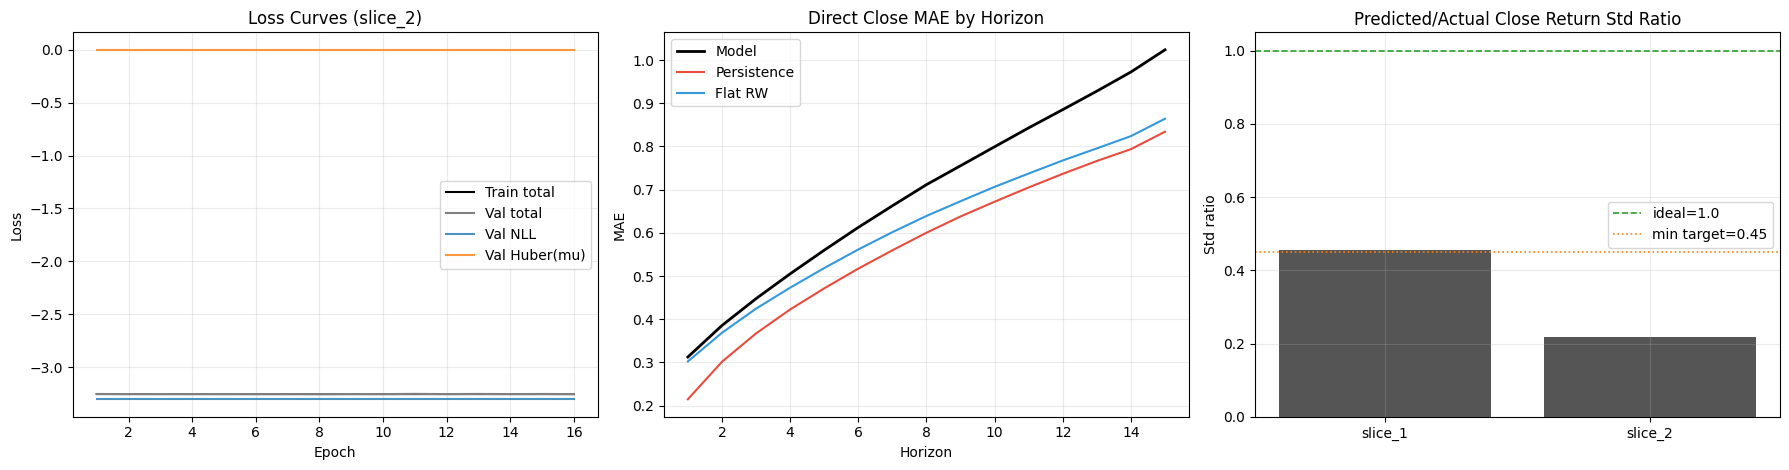

In [10]:
# Acceptance checks + diagnostics
latest = fold_results[-1]

mean_model_mae = float(summary_df['model_close_mae'].mean())
mean_persist_mae = float(summary_df['persist_close_mae'].mean())
mean_dir = float(summary_df['model_directional_acc_eps'].mean())
mean_bias = float(summary_df['model_bias'].mean())
mean_stepH_model = float(summary_df[f'step{HORIZON}_model_mae'].mean())
mean_stepH_persist = float(summary_df[f'step{HORIZON}_persist_mae'].mean())
mean_std_ratio = float(summary_df['pred_actual_std_ratio'].mean())

pred_close_path = latest['pred_future_df_det']['Close'].to_numpy()
is_monotonic = bool(np.all(np.diff(pred_close_path) >= 0) or np.all(np.diff(pred_close_path) <= 0))

acceptance = {
    'criterion_1_model_mae_20pct_better_than_persistence': mean_model_mae <= 0.8 * mean_persist_mae,
    'criterion_2_directional_accuracy_eps_at_least_0_52': mean_dir >= 0.52,
    f'criterion_3_step{HORIZON}_better_than_persistence': mean_stepH_model < mean_stepH_persist,
    'criterion_4_abs_bias_within_25pct_of_mae': abs(mean_bias) <= 0.25 * mean_model_mae,
    'criterion_5_non_monotonic_latest_prediction_path': not is_monotonic,
    'criterion_6_prediction_variance_not_collapsed': mean_std_ratio >= STD_RATIO_TARGET_MIN,
}

print('Selected lookback:', int(summary_df['window'].iloc[0]))
print('Acceptance checks:')
for k, v in acceptance.items():
    print(f'  {k}: {v}')

fig, axes = plt.subplots(1, 3, figsize=(18, 4.8), facecolor='white')

hist = latest['history_df']
axes[0].plot(hist['epoch'], hist['train_total'], label='Train total', color='black')
axes[0].plot(hist['epoch'], hist['val_total'], label='Val total', color='gray')
axes[0].plot(hist['epoch'], hist['val_nll'], label='Val NLL', color='#1f77b4', alpha=0.8)
if 'val_hub' in hist.columns:
    axes[0].plot(hist['epoch'], hist['val_hub'], label='Val Huber(mu)', color='#ff7f0e', alpha=0.8)
axes[0].set_title(f"Loss Curves ({latest['fold']})")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(alpha=0.25)
axes[0].legend()

axes[1].plot(horizon_stats['horizon'], horizon_stats['model_close_mae'], label='Model', color='black', linewidth=2.0)
axes[1].plot(horizon_stats['horizon'], horizon_stats['persistence_close_mae'], label='Persistence', color='#E74C3C')
axes[1].plot(horizon_stats['horizon'], horizon_stats['flat_close_mae'], label='Flat RW', color='#3498DB')
axes[1].set_title('Direct Close MAE by Horizon')
axes[1].set_xlabel('Horizon')
axes[1].set_ylabel('MAE')
axes[1].grid(alpha=0.25)
axes[1].legend()

axes[2].bar(summary_df['fold'], summary_df['pred_actual_std_ratio'], color='#555555')
axes[2].axhline(1.0, color='#2ca02c', linestyle='--', linewidth=1.2, label='ideal=1.0')
axes[2].axhline(STD_RATIO_TARGET_MIN, color='#ff7f0e', linestyle=':', linewidth=1.2, label=f'min target={STD_RATIO_TARGET_MIN}')
axes[2].set_title('Predicted/Actual Close Return Std Ratio')
axes[2].set_ylabel('Std ratio')
axes[2].grid(alpha=0.25)
axes[2].legend()

plt.tight_layout()
plt.show()


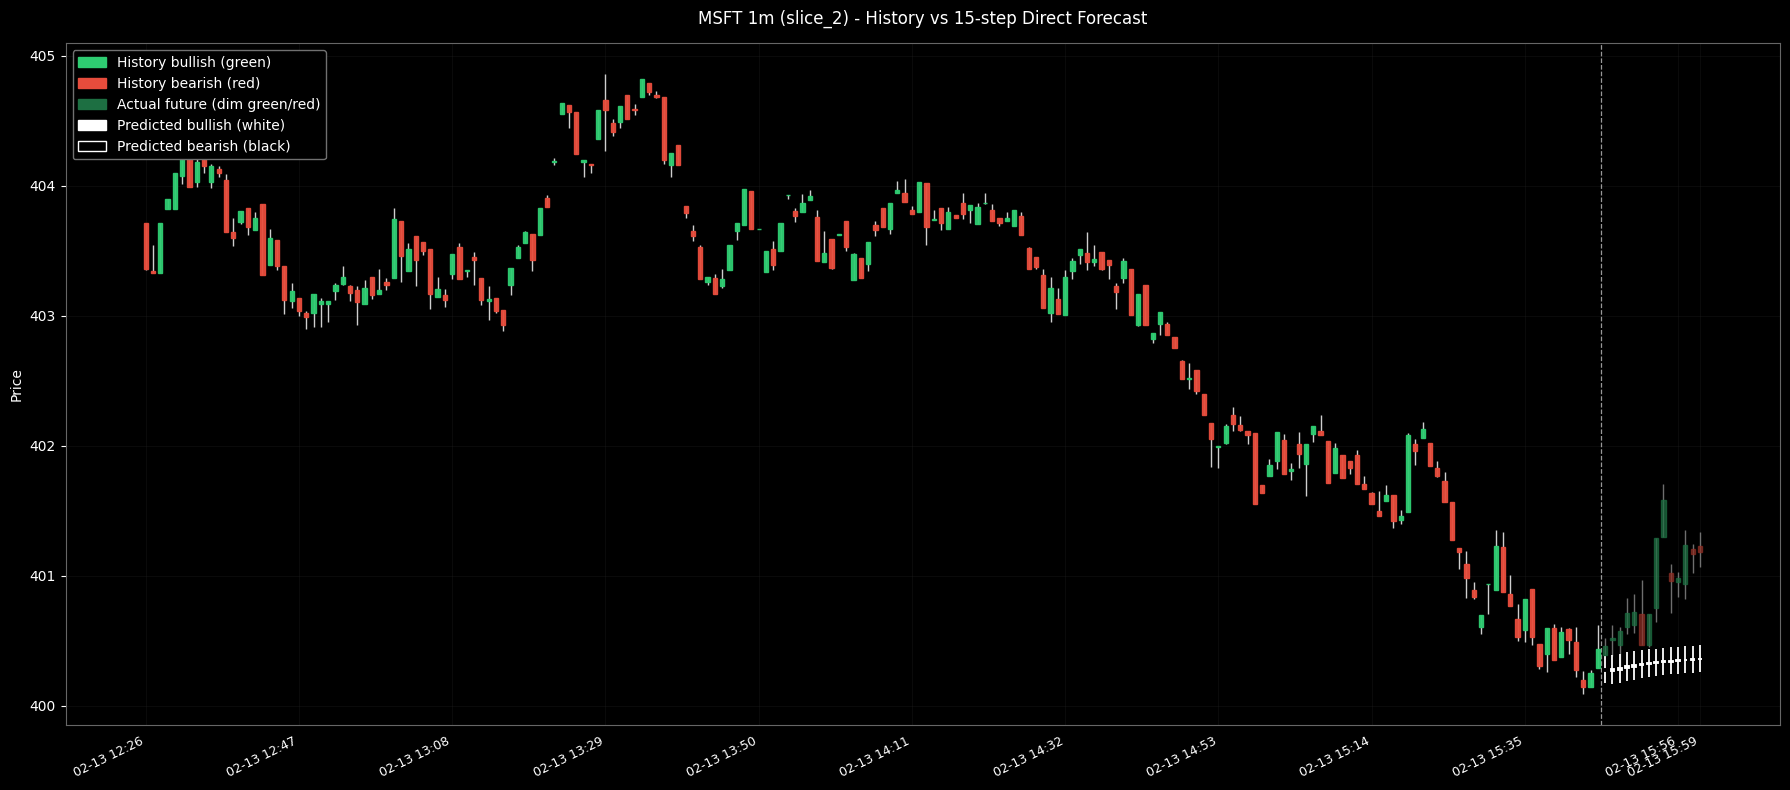

In [11]:
# Final candlestick chart (history green/red, predicted white/black)
def draw_candles(
    ax,
    ohlc: pd.DataFrame,
    start_x: int,
    up_edge: str,
    up_face: str,
    down_edge: str,
    down_face: str,
    wick_color: str,
    width: float = 0.62,
    lw: float = 1.0,
    alpha: float = 1.0,
):
    vals = ohlc[OHLC_COLS].to_numpy()
    for i, (o, h, l, c) in enumerate(vals):
        x = start_x + i
        bull = c >= o

        ax.vlines(x, l, h, color=wick_color, linewidth=lw, alpha=alpha, zorder=2)

        lower = min(o, c)
        height = abs(c - o)
        if height < 1e-8:
            height = 1e-6

        rect = Rectangle(
            (x - width / 2, lower),
            width,
            height,
            facecolor=up_face if bull else down_face,
            edgecolor=up_edge if bull else down_edge,
            linewidth=lw,
            alpha=alpha,
            zorder=3,
        )
        ax.add_patch(rect)


context_df = latest['context_df']
actual_future_df = latest['actual_future_df']
pred_future_df = latest['pred_future_df_det']

fig, ax = plt.subplots(figsize=(18, 8), facecolor='black')
ax.set_facecolor('black')

draw_candles(ax, context_df, 0, '#2ECC71', '#2ECC71', '#E74C3C', '#E74C3C', '#DADADA', width=0.58, lw=1.0, alpha=0.95)
draw_candles(ax, actual_future_df, len(context_df), '#1D6F42', '#1D6F42', '#8E2F25', '#8E2F25', '#9A9A9A', width=0.58, lw=1.0, alpha=0.72)
draw_candles(ax, pred_future_df, len(context_df), '#FFFFFF', '#FFFFFF', '#000000', '#000000', '#F5F5F5', width=0.50, lw=1.35, alpha=1.0)

ax.axvline(len(context_df) - 0.5, color='white', linestyle='--', linewidth=0.9, alpha=0.6)

idx = context_df.index.append(actual_future_df.index)
n = len(idx)
step = max(1, n // 10)
ticks = list(range(0, n, step))
if ticks[-1] != n - 1:
    ticks.append(n - 1)

labels = [idx[i].strftime('%m-%d %H:%M') for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=26, ha='right', color='white', fontsize=9)

ax.tick_params(axis='y', colors='white')
for sp in ax.spines.values():
    sp.set_color('#666666')

ax.grid(color='#252525', linewidth=0.6, alpha=0.35)
ax.set_title(f'MSFT 1m ({latest["fold"]}) - History vs {HORIZON}-step Direct Forecast', color='white', pad=14)
ax.set_ylabel('Price', color='white')

legend_elements = [
    Patch(facecolor='#2ECC71', edgecolor='#2ECC71', label='History bullish (green)'),
    Patch(facecolor='#E74C3C', edgecolor='#E74C3C', label='History bearish (red)'),
    Patch(facecolor='#1D6F42', edgecolor='#1D6F42', label='Actual future (dim green/red)'),
    Patch(facecolor='#FFFFFF', edgecolor='#FFFFFF', label='Predicted bullish (white)'),
    Patch(facecolor='#000000', edgecolor='#FFFFFF', label='Predicted bearish (black)'),
]
leg = ax.legend(handles=legend_elements, facecolor='black', edgecolor='#707070', framealpha=1.0, loc='upper left')
for t in leg.get_texts():
    t.set_color('white')

plt.tight_layout()
plt.show()


## Notes

- **V5 key fix**: Targets are NOT standardized. Raw log-returns (~1e-3 scale) used directly.
- **Sigma floor**: NLL clamps sigma >= 1e-4 to prevent variance collapse.
- **Directional penalty**: Soft loss penalizing wrong-sign predictions on close returns.
- **Huber delta=0.005**: Matched to return scale so Huber is effective, not just a constant.
- If `pred_actual_std_ratio` is near 1.0, variance collapse is fixed.
